In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import glob

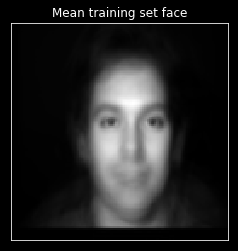

In [2]:
width  = 128
height = 128

def extract_names(dataset_path):
    included_extensions = ['jpg']
    dataset_dir = [fn for fn in os.listdir(dataset_path)
                if any(fn.endswith(ext) for ext in included_extensions)]
    return dataset_dir, dataset_path

def flatten_img(dataset_dir, X, dataset_path):
    image_names = dataset_dir
    for i in range(len(image_names)):
        img = plt.imread(dataset_path + image_names[i])
        X[i,:] = np.array(img, dtype='float64').flatten()   
    return X, image_names

(dataset_dir_train, dataset_path_train) = extract_names('train_images/')
(dataset_dir_test, dataset_path_test) = extract_names('test_images/')
X_train = np.ndarray(shape=(len(dataset_dir_train), height*width), dtype=np.float64)
X_test = np.ndarray(shape=(len(dataset_dir_test), height*width), dtype=np.float64)
(X_train, train_image_names) = flatten_img(dataset_dir_train, X_train, dataset_path_train)
(X_test, test_image_names) = flatten_img(dataset_dir_test, X_test, dataset_path_test)

#mean face
Psi = np.zeros((1,height*width))

for i in X_train:
    Psi = np.add(Psi,i)

Psi = np.divide(Psi,float(len(train_image_names))).flatten()

plt.imshow(Psi.reshape(height, width), cmap='gray')
plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.title('Mean training set face')
plt.show()

Cumulative proportion of variance explained vector: 
[0.23235041 0.37895912 0.49432499 0.55185974 0.60668309 0.63980378
 0.67235332 0.6985845  0.72397351 0.74465043 0.76421396 0.7812863
 0.79753104 0.8124543  0.8247341  0.83645775 0.84668655 0.85598756
 0.86512803 0.87372205 0.88149909 0.88858318 0.89531393 0.90173217
 0.90762691 0.91319638 0.91836252 0.92327092 0.92758072 0.93162317
 0.93543238 0.93880399 0.94205004 0.94517621 0.94823099 0.95120085
 0.95385472 0.95634163 0.95877871 0.96113661 0.96332797 0.96540232
 0.96735216 0.9692194  0.97099616 0.97259629 0.97414038 0.97566125
 0.97715869 0.9785079  0.97981137 0.98107809 0.98227512 0.98344476
 0.98458438 0.98566166 0.98668211 0.98765851 0.98861415 0.98949191
 0.99033079 0.99113509 0.99191795 0.99268996 0.99342899 0.99410282
 0.99476333 0.99533717 0.9958893  0.99637774 0.99684463 0.99729203
 0.9977266  0.99812724 0.99848917 0.99879852 0.9990713  0.99933861
 0.99959179 0.99978277 0.99991932 1.         1.        ]


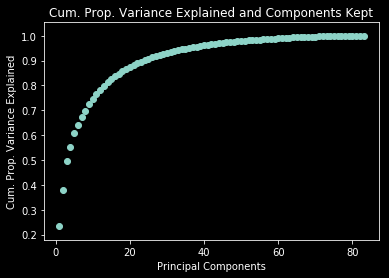

In [3]:
#normalised faces: mean subtraction
Phi_train = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    Phi_train[i] = np.subtract(X_train[i],Psi)
    
#covariance matrix
C = np.cov(Phi_train)
#C = np.divide(C,8.0)
eigenvalues, eigenvectors, = np.linalg.eig(C)

eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) 
            for index in range(len(eigenvalues))]
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in 
            range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in 
            range(len(eigenvalues))]

var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explained and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Explained')
plt.scatter(num_comp, var_comp_sum)
plt.show()

In [4]:
#choose the necessary number of principle components
E = np.array(eigvectors_sort[:15]).transpose()

E = np.dot(X_train.transpose(),E)
E = E.transpose()

w = np.array([np.dot(E,i) for i in Phi_train])

#threshold determination
def threshold(img,train_image_names,E,w,obj):
    global minval
    train_face        = plt.imread('train_images/'+img)
    P = np.array(train_face, dtype='float64').flatten()
    Phi_i = np.subtract(P,Psi)
    w_train = np.dot(E, Phi_i)
    diff  = w - w_train
    norms = np.linalg.norm(diff, axis=1)
    norms=np.delete(norms, obj)
    index = np.argmin(norms)
    minval=norms[index]
    
rast = np.ndarray(shape=(len(train_image_names), 1), 
    dtype=np.float64)
for i in range(len(train_image_names)):
    threshold(train_image_names[i],train_image_names,E,w,i)
    rast[i]=minval

theta=0.8*max(rast)

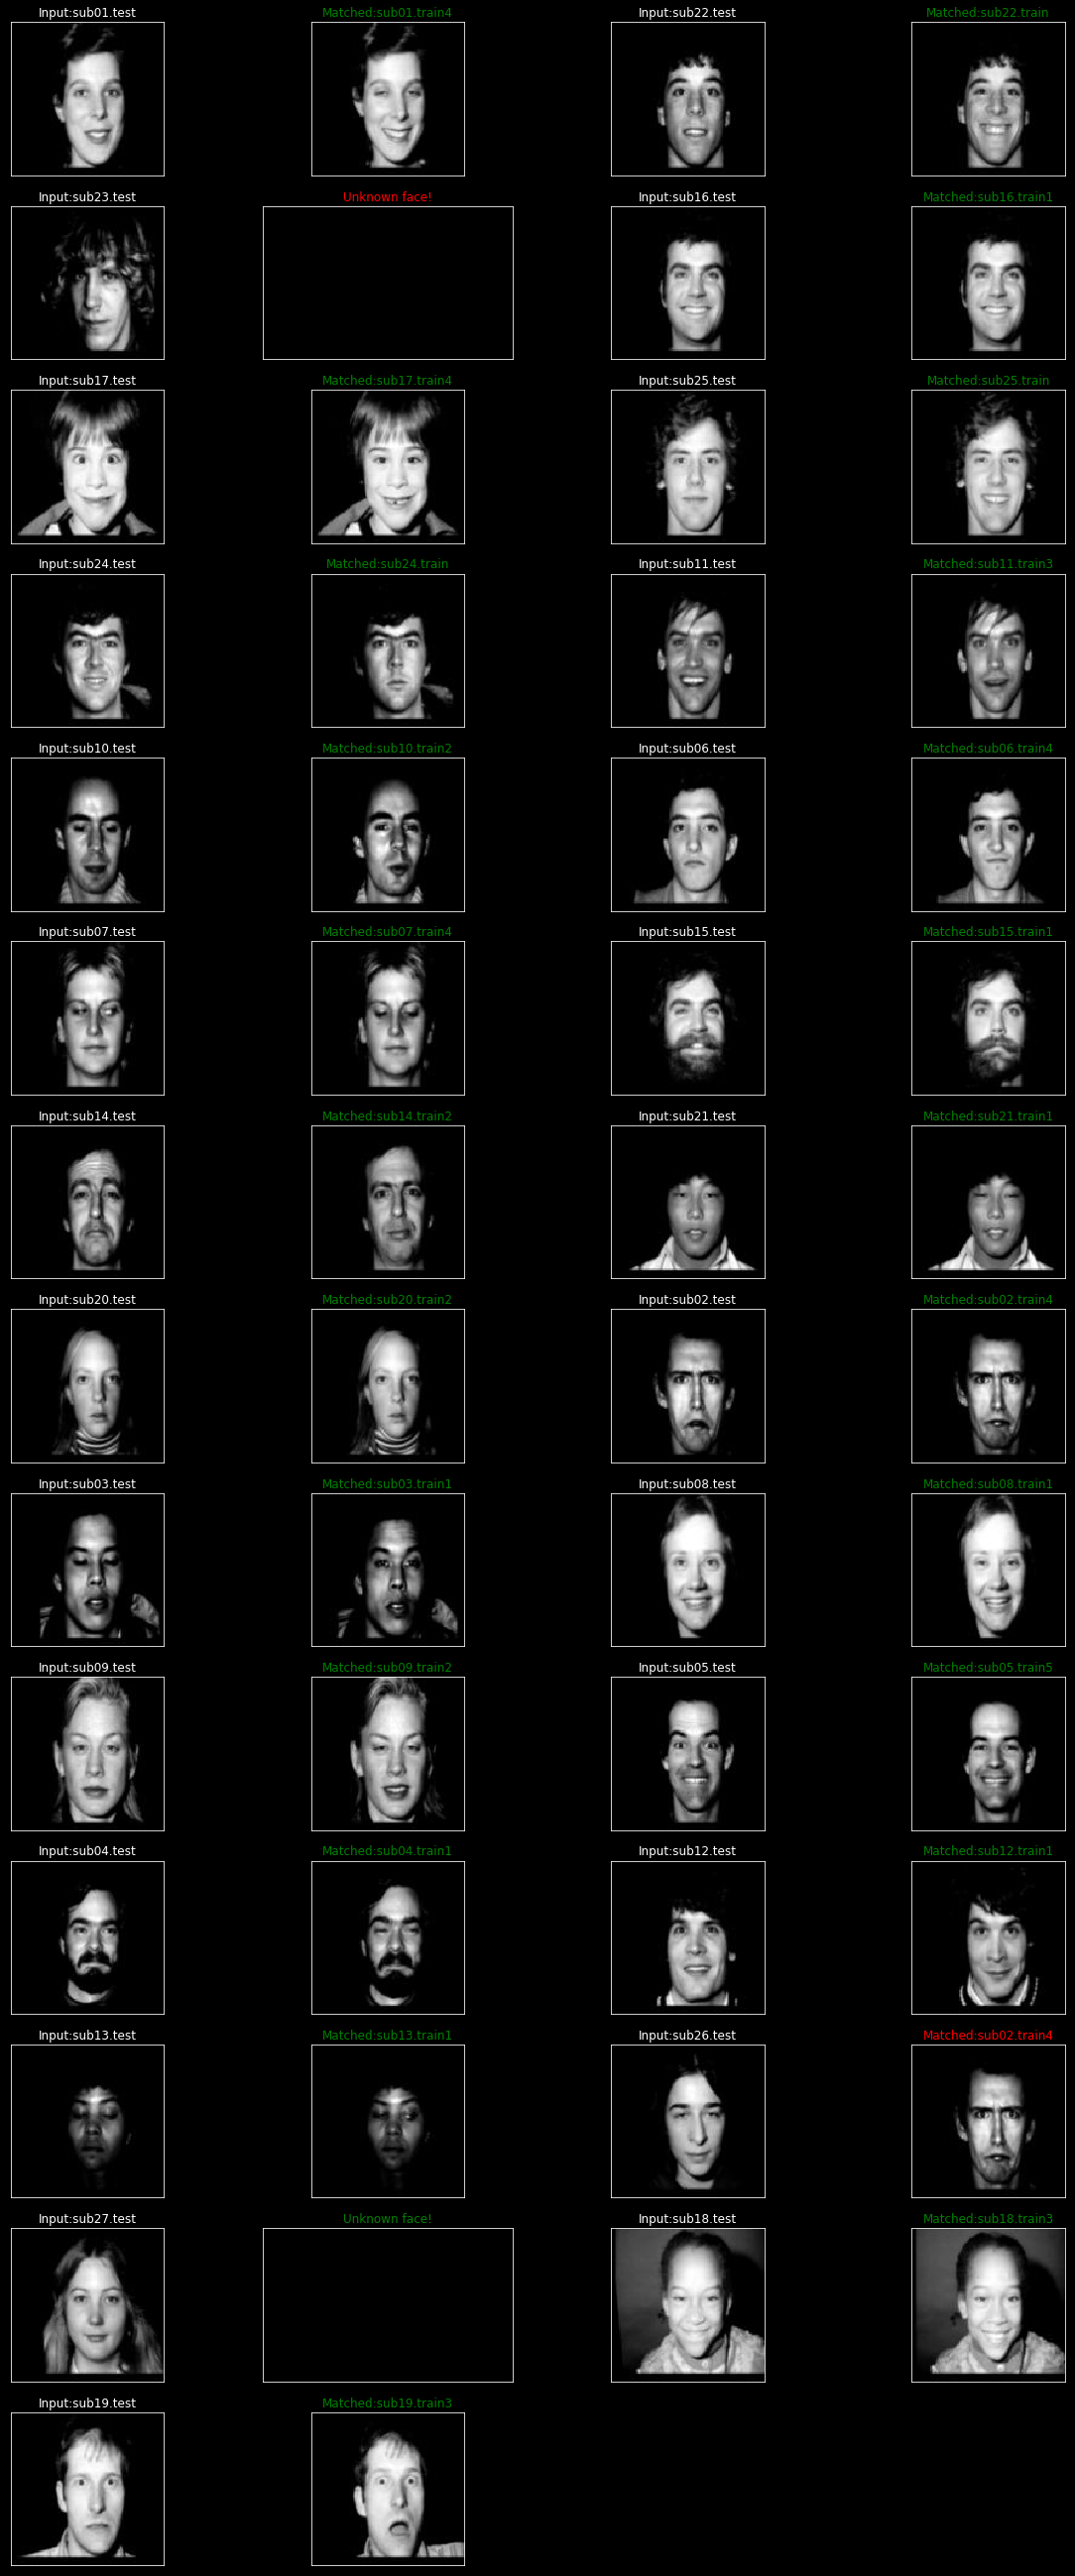

Correct predictions: 25/27 


In [5]:
count        = 0
num_images   = 0
correct_pred = 0
def recogniser(img, train_image_names,E,w):
    global count,highest_min,num_images,correct_pred
    unknown_face        = plt.imread('test_images/'+img)
    num_images          += 1
    P = np.array(unknown_face, dtype='float64').flatten()
    Phi_i = np.subtract(P,Psi)
    
    plt.subplot(14,4,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft=False, labelbottom=False, 
        bottom=False,top=False,right=False,left=False, 
        which='both')
    count+=1
    
    w_unknown = np.dot(E, Phi_i)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)

    plt.subplot(14,4,1+count)
    if norms[index] < theta: #It's a known face
        if img.split('.')[0] == train_image_names[index].split('.')[0]:
            plt.title('Matched:'+'.'.join(
                train_image_names[index].split('.')[:2]), color='g')
            plt.imshow(imread('train_images/'+ train_image_names[index]), cmap='gray')
            correct_pred += 1
        else:
            plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
            plt.imshow(imread('train_images/'+train_image_names[index]), cmap='gray')
    else: #It's an unknown face
        if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names]:
            plt.title('Unknown face!', color='g')
            correct_pred += 1
        else:
            plt.title('Unknown face!', color='r')
            plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
            plt.subplots_adjust(right=1.2, top=2.5)
            
    plt.tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
    count+=1

fig = plt.figure(figsize=(15, 15))
for i in range(len(test_image_names)):
    recogniser(test_image_names[i], train_image_names,E,w)

plt.show()

print('Correct predictions: {}/{} '.format(correct_pred, num_images))